In [3]:
import numpy as np
from scipy.sparse.linalg import expm
from scipy.constants import hbar, pi
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from sim_functions import time_evolve, gen_ham_free, gen_ham_plus, gen_ham_minus

# Note: double check these at some point
m = 85.47*1.6605e-27 # Rb-85 mass
kb = 1.38064852e-23 # Boltzmann's constant
omega_2 = 2*pi*(384.230406373e12 - 1.264888e9) # Beam 2 freq.
omega_1 = 2*pi*(384.230406373e12 + 1.770843e9) # Beam 1 freq.
omega_eg = omega_1 - omega_2 # Hyperfine splitting.
k_eff = (omega_1+omega_2)/(2.998e8) # Effective wavevector.
dR = (hbar*(k_eff)**2)/(2*m) # two-photon recoil shift
print(dR/2*pi)

151374.93221726542


### Copy from single atom sims

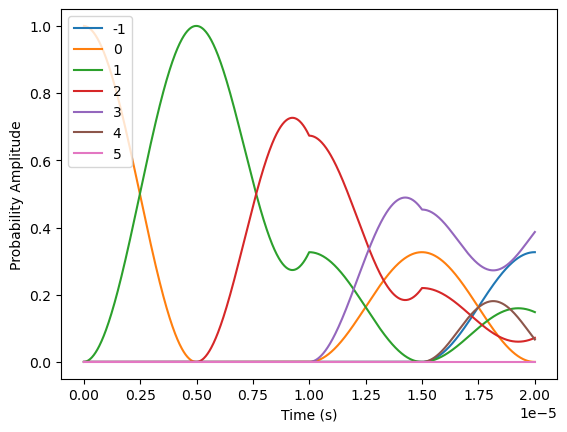

In [170]:
N = 1000
Temp = 50e-6
sigma = np.sqrt(kb*Temp/m)
atom_veloc = np.random.normal(loc = 0, scale = sigma, size = N)

n_min = -1
n_max = 5
n_tot = n_max - n_min + 1
basis = np.arange(n_min, n_max + 1)

Rabi_plus = 2*pi*100000
Rabi_minus = 2*pi*100000
Rabi_plus_time = 2*pi/Rabi_plus
Rabi_minus_time = 2*pi/Rabi_minus

H0 = gen_ham_free(basis = basis,
                  delta_L = 1*dR,
                  delta_D = 0,
                  delta_R = dR,
)

Hplus = gen_ham_plus(basis = basis,
                  phi_L = 0,
                  omega_R_plus = Rabi_plus,
)

Hminus = gen_ham_minus(basis = basis,
                  phi_L = 0,
                  omega_R_minus = Rabi_minus,
)

time = np.linspace(0, 2*Rabi_plus_time, 1000)
time_step = time[1]-time[0]

data = np.zeros((np.size(basis), np.size(time)))

state_vec = np.zeros((np.size(basis), 1), dtype=np.complex128)
state_vec[1] = 1
for i in range(int(np.size(time)/4)):
    state_vec = time_evolve(time_step, Hplus + H0) @ state_vec
    square = np.abs(state_vec)**2
    data[:,i] = square[:,0]
    
for i in range(int(np.size(time)/4), int(np.size(time)/2)):
    state_vec = time_evolve(time_step, Hminus + H0) @ state_vec
    square = np.abs(state_vec)**2
    data[:,i] = square[:,0]
    
for i in range(int(np.size(time)/2), int(np.size(time)*3/4)):
    state_vec = time_evolve(time_step, Hplus + H0) @ state_vec
    square = np.abs(state_vec)**2
    data[:,i] = square[:,0]
    
for i in range(int(np.size(time)*3/4), int(np.size(time))):
    state_vec = time_evolve(time_step, Hminus + H0) @ state_vec
    square = np.abs(state_vec)**2
    data[:,i] = square[:,0]

# print(np.transpose(data))
plt.plot(time,np.transpose(data))
plt.legend(basis,loc='upper left')
plt.xlabel('Time (s)')
plt.ylabel('Probability Amplitude')
plt.show()

### Output final momentum distribution with no intermediate time steps

In [5]:
N = 10000
Temp = 0.1e-6
sigma = np.sqrt(kb*Temp/m)
atom_veloc = np.random.normal(loc = 0, scale = sigma, size = N)

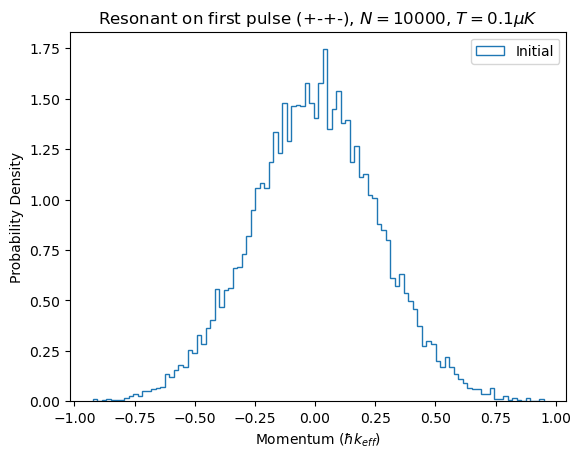

In [ ]:
# This is a test where im taking the single atom alternating pulse sim and applying it to a distribution of atoms
# I will calcualte the final momentum distribution but not intermediate time steps
# The basis is -2 to 2, the atom starts in (1,0,0,0,0) and the laser detuning is set to be resonant with only the first set of coupled states
# The resulting distribution should be a mix with the majority in 2hbark and near zero in 1hbark

n_min = -1
n_max = 5
n_tot = n_max - n_min + 1
basis = np.arange(n_min, n_max + 1)

Rabi_plus = 2*pi*100000
Rabi_minus = 2*pi*100000
Rabi_plus_time = 2*pi/Rabi_plus
Rabi_minus_time = 2*pi/Rabi_minus

Hplus = gen_ham_plus(basis = basis,
                  phi_L = 0,
                  omega_R_plus = Rabi_plus,
)

Hminus = gen_ham_minus(basis = basis,
                  phi_L = 0,
                  omega_R_minus = Rabi_minus,
)

data = np.zeros((np.size(basis), np.size(atom_veloc)))

for v in range(len(atom_veloc)):
    state_vec = np.zeros((np.size(basis), 1), dtype=np.complex128)
    state_vec[1] = 1

    H0 = gen_ham_free(basis = basis,
                  delta_L = 1*dR, #-3
                  delta_D = k_eff*atom_veloc[v],
                  delta_R = dR,
    )

    state_vec = time_evolve(Rabi_plus_time/2, Hplus + H0) @ state_vec
    
    H0 = gen_ham_free(basis = basis,
                  delta_L = 1*dR, #1
                  delta_D = -k_eff*atom_veloc[v],
                  delta_R = dR,
    )

    state_vec = time_evolve(Rabi_minus_time/2, Hminus + H0) @ state_vec
    
    H0 = gen_ham_free(basis = basis,
                  delta_L = 1*dR, #1
                  delta_D = k_eff*atom_veloc[v],
                  delta_R = dR,
    )

    state_vec = time_evolve(Rabi_plus_time/2, Hplus + H0) @ state_vec
    
    H0 = gen_ham_free(basis = basis,
                  delta_L = 1*dR, #-3
                  delta_D = -k_eff*atom_veloc[v],
                  delta_R = dR,
    )

    state_vec = time_evolve(Rabi_minus_time/2, Hminus + H0) @ state_vec

    square = np.abs(state_vec)**2
    data[:,v] = square[:,0]

init_mom_dist = atom_veloc*m



init_mom_dist_tiled = np.tile(init_mom_dist, (len(basis),1))
basis_tiled = np.transpose(np.tile(basis, (len(atom_veloc),1)))

final_mom_dist_tiled = init_mom_dist_tiled + (hbar*k_eff*basis_tiled)


final_mom_dist = np.ravel(final_mom_dist_tiled)

state_fractions = np.ravel(data)

final_mom_dist = final_mom_dist/(hbar*k_eff)

init_mom_dist = init_mom_dist/(hbar*k_eff)

plt.hist(x = init_mom_dist, bins = 100, histtype='step',density=True,label='Initial')
#plt.hist(x = final_mom_dist, bins = 250, weights=state_fractions, histtype='step',density=True, label='Final')
plt.title(rf"Resonant on first pulse (+-+-), $N={N}$, $T={Temp*1e6:.3g}\mu K$")
plt.ylabel('Probability Density')
plt.xlabel(r"Momentum ($\hbar k_{eff}$)")
plt.legend()
plt.show()

    